# CSC421 Spring 2022 Project  
### Author: George Tzanetakis 
### Completed by: Taylor Koch
### V00809341

------------


# Mini-Project 2 
## Path-finding in hexagonal grids 

This project is based on material from Chapter 3 Solving Problems by Searching. You will need to review that material on your own.

This project is based on hexagonal grids 
https://www.redblobgames.com/grids/hexagons/
Many computer games use hexagonal grids. 

1. Describe how path finding from a particular hexagonal grid location A to another hexagonal grid location B can be expressed as a search problem. Be precise about the formulation and use the one of the coordinate systems described above in order to illustrate this formulation with a particular example. **(Basic - 2 points)**
2. Assume that some hexagonal locations contain an obstacles. 
Show how you can calculate a "distance" between two hexagonal locations and describe how it could be used as a heuristic for informed search strategies for the path finding problem with obstacles **(Basic - 2 points)** 
3. Write code that given two hexagonal grid coordinates finds a path that connects them using uninformed search strategies **(Expected - 2 points)**
4. Write code that given two cells in a hexagonal grid expressed by their corresponding grid coordinates and a list of obstacles (expressed by their corresponding grid coordinates) finds a path that connects them and avoids obstacles using greedy and A\*-search. Use an appropriately defined distance on the hexagonal grid for guiding the A\* search **(Expected - 2 points)**. 
5. Write code that draws a hexagon grid with two locations and obstacles and displays the path found. Use your visualization to illustrate how different search algorithms operate. **(Advanced - 2 points)** 





---------
### 1. To express such a problem as a search problem:

I will consider a hexagonal grid with 9 hexagons, arranged using an "odd-r" horizontal layout. The first number is the column number, and the second number is the row number.

**Set of states / State Space:** Since search problems deal with atomic representations of the world, the set of states is the set of all grid coordinates. 

![](images\hex-grid.png)

**Initial State:** The grid coordinates of the starting location A. Ex: (0, 0)
![](images\AB-hex-grid.png)

**Goal State:** The grid coordinates of the goal location B. Ex: (1, 1)
![](images\AB-hex-grid-goal.png)

**Actions set:** At a certain grid location, the set of 6 or less actions corresponding to moving to each neighbouring hex location.

**Transition model:** The function describing the resulting hex coordinate when taking each action. In the initial state above, the only available moves are "Right" or "Down-Right", which results in (1,0) or (0,1), respectively. 

**Action cost:** The cost of each movement is one.


Constructed in this way, we can then simulate paths by selecting moves in each state, and select the shortest path (the path with the least total action cost). 



### 2. Calculating a "distance" between two hexagonal locations:

To calculate a distance between two hexagonal locations, (a, b) and (c, d):

distance = | a - c | + | b - d |

Using this distance formula, we can select the best node in the frontier to expand next, by calculating the distance from each node in the frontier to the goal and selecting the shortest one.



### 3. Code for uninformed search

Using code from the aima repository, for this question I wrote a subclass of the Problem class called HexProblem. The "graph" passed to the Problem is a collection of coordinates in a hexgrid. For the actions, I appended different coordinate translations (depending on whether the current coordinate's row was even or odd) and then removed the impossible moves (at the edges of the grid). Since the action moves are encoded as the next states themselves, the result function simply returns the "action" as the new state if it is a viable move.
Once a solution is found, the path is traced back from the goal node, and the initial state is prepended to the path for ease of drawing.

In [15]:
# Uninformed Search
# using code from aima repository
from search import *

def createHexGridGraph(gridsize):
    dim = np.sqrt(gridsize)
    if(dim != np.ceil(dim,dtype=float)):
        raise Exception("Gridsize is not a perfect square. Try 16, 25, 36, etc.")
    dim = int(dim)
    global maxdim 
    maxdim = dim
    arr = []
    for i in range(dim):
        for j in range(dim):
            arr.append((i, j))
    return arr

class HexProblem(Problem):
    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph
    
    def actions(self, state):
        acts = []
        acts.append((state[0] - 1, state[1] + 0)) #left
        acts.append((state[0] + 1, state[1] + 0)) #right
        if(state[1] % 2 != 0): #odd row
            acts.append((state[0] + 0, state[1] - 1)) #up_left
            acts.append((state[0] + 1, state[1] - 1)) #up_right
            acts.append((state[0] + 0, state[1] + 1)) #down_left
            acts.append((state[0] + 1, state[1] + 1)) #down_right
        else: #even row
            acts.append((state[0] - 1, state[1] - 1)) #up_left
            acts.append((state[0] + 0, state[1] - 1)) #up_right
            acts.append((state[0] - 1, state[1] + 1)) #down_left
            acts.append((state[0] + 0, state[1] + 1)) #down_right
        global maxdim
        
        #remove actions that would move outside grid
        acts[:] = [x for x in acts if not ((x[0] < 0) or (x[1] < 0) or (x[0] > maxdim) or (x[1] > maxdim))] 
        
        return acts
            
    def result(self, state, action):
        if action in self.actions(state):
            return action

graph = createHexGridGraph(64)
hex_problem = HexProblem((1,5), (5,3), graph)
target_node = breadth_first_tree_search(hex_problem)
path = target_node.solution()
path.insert(0, (1,5)) #adding initial state to front of the path
print(path)

[(1, 5), (2, 5), (3, 5), (4, 5), (5, 4), (5, 3)]


As we can see, the final path is comprised of 5 moves, starting at (1, 5) and ending at (5, 3)

### 4. Code for informed search

The first informed search I implemented is the greedy search. Using the same HexProblem above, I defined a slightly different problem HexProblemHeuristic. The only differences are the exclusion of any obstacle coordinate from available moves and the inclusion of a heuristic function "h". The heuristic function used is the same as the one I described in question 2. For both the informed searches, I set the display=True flag so that the output would display the explored paths memory.

In [16]:
# Greedy Search
# using code from aima repository

class HexProblemHeuristic(Problem):
    def __init__(self, initial, goal, graph, obstacles=[]):
        Problem.__init__(self, initial, goal)
        self.graph = graph
        self.obstacles = obstacles
        
    def actions(self, state):
        acts = []
        acts.append((state[0] - 1, state[1] + 0)) #left
        acts.append((state[0] + 1, state[1] + 0)) #right
        if(state[1] % 2 != 0): #odd row
            acts.append((state[0] + 0, state[1] - 1)) #up_left
            acts.append((state[0] + 1, state[1] - 1)) #up_right
            acts.append((state[0] + 0, state[1] + 1)) #down_left
            acts.append((state[0] + 1, state[1] + 1)) #down_right
        else: #even row
            acts.append((state[0] - 1, state[1] - 1)) #up_left
            acts.append((state[0] + 0, state[1] - 1)) #up_right
            acts.append((state[0] - 1, state[1] + 1)) #down_left
            acts.append((state[0] + 0, state[1] + 1)) #down_right
        global maxdim
        
        #remove actions that would move outside grid or into obstacles
        acts[:] = [x for x in acts if not ((x[0] < 0) or (x[1] < 0) or (x[0] > maxdim) or (x[1] > maxdim) or x in self.obstacles)]
        
        return acts
            
    def result(self, state, action):
        if action in self.actions(state):
            return action
    
    def h(self, node):
        return (abs(node.state[0] - self.goal[0]) + abs(node.state[1] - self.goal[1]))

def heuristic_f(node):
    distance = abs(node.state) + abs()

graph = createHexGridGraph(64)
obstacles = [(5, 4), (4, 3), (4, 2), (7, 1), (2, 3)]
hex_problem = HexProblemHeuristic((1, 5), (5, 3), graph, obstacles)
target_node = best_first_graph_search(hex_problem, hex_problem.h, display=True)
path = target_node.solution()
path.insert(0, (1,5)) #adding initial state to front of the path
print(path)

9 paths have been expanded and 16 paths remain in the frontier
[(1, 5), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5), (6, 4), (5, 3)]


The next search I implemented was the A* Search. The code is identical, except for the search function being called. The heuristic function is the same as the greedy search, but it is handled differently by the A* search function. Instead of only using the heuristic function to inform the next move, it also considers the path cost at the nodes. 

In [17]:
# A* Search
# using code from aima repository

class HexProblemHeuristic(Problem):
    def __init__(self, initial, goal, graph, obstacles=[]):
        Problem.__init__(self, initial, goal)
        self.graph = graph
        self.obstacles = obstacles
        
    def actions(self, state):
        acts = []
        acts.append((state[0] - 1, state[1] + 0)) #left
        acts.append((state[0] + 1, state[1] + 0)) #right
        if(state[1] % 2 != 0): #odd row
            acts.append((state[0] + 0, state[1] - 1)) #up_left
            acts.append((state[0] + 1, state[1] - 1)) #up_right
            acts.append((state[0] + 0, state[1] + 1)) #down_left
            acts.append((state[0] + 1, state[1] + 1)) #down_right
        else: #even row
            acts.append((state[0] - 1, state[1] - 1)) #up_left
            acts.append((state[0] + 0, state[1] - 1)) #up_right
            acts.append((state[0] - 1, state[1] + 1)) #down_left
            acts.append((state[0] + 0, state[1] + 1)) #down_right
        global maxdim
        
        #remove actions that would move outside grid or into obstacles
        acts[:] = [x for x in acts if not ((x[0] < 0) or (x[1] < 0) or (x[0] > maxdim) or (x[1] > maxdim) or x in self.obstacles)]
        
        return acts
            
    def result(self, state, action):
        if action in self.actions(state):
            return action
    
    def h(self, node):
        return (abs(node.state[0] - self.goal[0]) + abs(node.state[1] - self.goal[1]))

def heuristic_f(node):
    distance = abs(node.state) + abs()

graph = createHexGridGraph(64)
obstacles = [(5, 4), (4, 3), (4, 2), (7, 1), (2, 3)]
hex_problem = HexProblemHeuristic((1, 5), (5, 3), graph, obstacles)
target_node = astar_search(hex_problem, hex_problem.h, display=True)
path = target_node.solution()
path.insert(0, (1,5)) #adding initial state to front of the path
print(path)

19 paths have been expanded and 17 paths remain in the frontier
[(1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 4), (5, 3)]


The difference between these two searches is clearer with the below visualization.

### 5. Visualization

For this section I created a PointyHex object for each hex coordinate, so that the grid can be drawn by calculating the center of each hex and then calculating all the corners. The presence of an object (such as an obstacle, initial "A", or goal "B") is stored at each hex coordinate individually. 

First, the hex_grid is created, specifying the size of each hex, and the number of hexes in the grid (must be a perfect square). Next, the objects are placed on the grid. The obstacles list is created in the previous two searches and is reused here. The offset is specified, which is added to each x and y for each coordinate drawn, in order to pad the upper and left sides of the images with blank space. I used half a hexagon's width in this case.
Finally, the drawGrid function calls drawHexagon for each hex, then draws all the objects with drawObj, then draws the path found with drawPath (the path is computed and reused from the previous two searches).

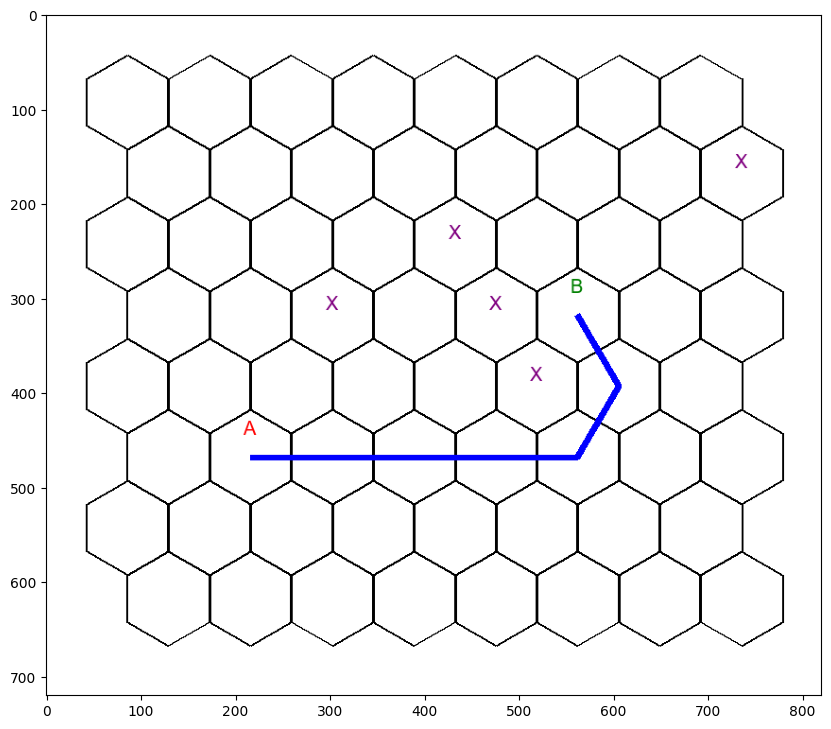

In [18]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import imshow,rcParams
from PIL import Image, ImageDraw, ImageFont

class PointyHex:
    "A pointy-hex location in a hex grid"
    def __init__(self, size, row, col, obj=[]):
        self.size = size
        self.width = np.sqrt(3) * size # sqrt(3) == sin(60deg) * 2
        self.height = size * 2
        self.row = row
        self.col = col
        self.obj = []
        self.state = 0
        
        if(col % 2 == 0):
            self.center_x = (self.width / 2) + (row * self.width)
        else:
            self.center_x = self.width + (row * self.width)
        self.center_y = (self.height / 2) + (col * (self.height * 0.75))
        
    def getCorner(self, i):
        angle_deg = 60 * i + 30
        angle_rad = (np.pi / 180) * angle_deg
        return (self.center_x + (np.cos(angle_rad) * self.size), self.center_y + (np.sin(angle_rad) * self.size))
    
    def getCenter(self):
        return (self.center_x, self.center_y)
    
    def getWidth(self):
        return self.width
    
    def getHeight(self):
        return self.height
        
    def getObj(self):
        return self.obj
    
    def addObj(self, obj):
        if obj not in self.obj:
            self.obj.append(obj)
            
    def delObj(self, obj):
        if obj in self.obj:
            self.obj.remove(obj)
        
    def setObjList(self, objlist):
        self.obj = objlist
        
def createHexGrid(hexsize, gridsize):
    dim = np.sqrt(gridsize)
    if(dim != np.ceil(dim,dtype=float)):
        raise Exception("Gridsize is not a perfect square. Try 16, 25, 36, etc.")
    dim = int(dim)
    global maxdim 
    maxdim = dim
    arr = np.empty((dim,dim),dtype=PointyHex)
    for i in range(dim):
        for j in range(dim):
            arr[i][j] = PointyHex(hexsize, i, j)
    return arr

def drawGrid(hexgrid, drawimage, offset=50, path=[]): 
    for i in np.reshape(hexgrid, hexgrid.size):
        drawHexagon(i, drawimage, offset)
    drawObj(hexgrid, drawimage, offset)
    drawPath(hexgrid, drawimage, offset, path)

def drawHexagon(hexagon, drawimage, offset):
    points = []
    for i in range(7):
        if (i==6):
            point = hexagon.getCorner(0)
        else:
            point = hexagon.getCorner(i)
        point = (point[0] + offset, point[1] + offset)
        points.append(point)
        #print(point)
        drawimage.line(points, width=2, fill="black", joint="curve")
        
def drawObj(hexgrid, drawimage, offset):
    font = ImageFont.truetype("arial.ttf", 20)
    for i in np.reshape(hexgrid, hexgrid.size):
        objlist = i.getObj()
        if objlist:
            num_objs = len(objlist)
            if (num_objs == 1):
                loc = i.getCenter()
                a_b_loc = ((loc[0] + offset), (loc[1] + 0.6*offset))
                o_loc = ((loc[0] + offset), (loc[1] + offset))
                val = objlist[0]
                if(val == "A"):
                    drawimage.text(a_b_loc, "A", fill="red", anchor="md", font=font)
                elif(val == "B"):
                    drawimage.text(a_b_loc, "B", fill="green", anchor="md", font=font)
                elif(val == "X"):
                    drawimage.text(o_loc, "X", fill="purple", anchor="md", font=font)
                else:
                    drawimage.text(a_b_loc, val, fill="blue", anchor="md", font=font)
            else:
                pass
            
def drawPath(hexgrid, drawimage, offset, path):
    if path:
        points = []
        for i in range(len(path)):
            center = hexgrid[path[i][0]][path[i][1]].getCenter()
            points.append((center[0] + offset, center[1] + offset))
        drawimage.line(points, width=6, fill="blue", joint="curve")

        
        

hex_grid = createHexGrid(50, 64)
a_coord = hex_problem.initial
b_coord = hex_problem.goal
hex_grid[a_coord[0]][a_coord[1]].addObj("A")
hex_grid[b_coord[0]][b_coord[1]].addObj("B")
for x in obstacles:
    hex_grid[x[0]][x[1]].addObj("X")

im = Image.new("RGB", (820, 720), "#ffffff")
draw = ImageDraw.Draw(im)

off_set = hex_grid[0][0].getWidth() * 0.5
drawGrid(hex_grid, draw, offset=off_set, path=path)

rcParams['figure.figsize'] = [10, 10]
rcParams['figure.dpi'] = 100

imshow(im)

The output for this function was calculated after running "Greedy Search", so the visualization shown above is the one for the Greedy Search (using the calculated path). The other output for this function was saved to a file after running A* Search and then the above code (with the A* calculated path). It is displayed below.

![](images/astar.png)

The difference between Greedy and A* is much more apparent with the visualization. While the Greedy search is happy to use the distance heuristic to head towards an obstacle (because it is closer to the goal without considering the obstacle) and then move around the obstacle to the goal and consider it a valid path and return, the A* search continues to explore paths until it finds one that matches the minimum path that comes as close to matching the heuristic function as possible. It found the shortest path. 